<a href="https://colab.research.google.com/github/sergekamanzi/Sound-Clustering-HMMs/blob/main/soundclustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install librosa  plotly --quiet

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving unlabelled_sounds.zip to unlabelled_sounds.zip


In [ ]:
import zipfile
import os
import librosa

zip_path = list(uploaded.keys())[0]  # gets the uploaded file name, e.g. 'sounds.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('sounds_folder')  # extracts to folder 'sounds_folder'

print("Files extracted to sounds_folder/")

Files extracted to sounds_folder/


In [ ]:
folder_path = '/content/sounds_folder/unlabelled_sounds'  # Change this to your folder path

# List all audio files (e.g., .wav, .mp3, .flac, .ogg)
audio_files = [f for f in os.listdir(folder_path) if f.endswith(('.wav', '.mp3', '.flac', '.ogg'))]

# Print total and sample files
print(f"Total audio files extracted: {len(audio_files)}")
print(f"Sample files: {audio_files[:10]}")

Total audio files extracted: 3000
Sample files: ['2495.wav', '1775.wav', '2320.wav', '2833.wav', '915.wav', '1149.wav', '2982.wav', '809.wav', '1886.wav', '1222.wav']


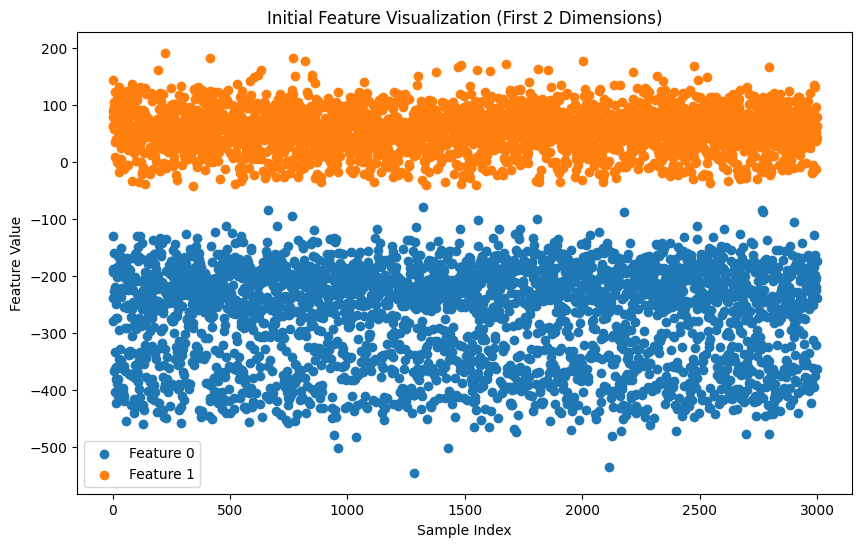

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initial visualization using pair plots (limited to first two dimensions due to high dimensionality)
plt.figure(figsize=(10, 6))
for i in range(min(2, features.shape[1])):
    plt.scatter(range(len(features)), features[:, i], label=f'Feature {i}')
plt.title("Initial Feature Visualization (First 2 Dimensions)")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

Now, let's extract some features from the audio files. We will use Mel-Frequency Cepstral Coefficients (MFCCs) as features, which are commonly used in audio analysis.

In [ ]:
%%capture
import numpy as np

features = []
sample_rate = None  # To store the sample rate of the first file

for i, file_name in enumerate(audio_files):
    file_path = os.path.join(folder_path, file_name)
    try:
        y, sr = librosa.load(file_path, sr=None)  # Load audio file, preserving original sample rate
        if sample_rate is None:
            sample_rate = sr  # Store sample rate of the first file

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40) # You can adjust n_mfcc
        features.append(mfccs.mean(axis=1)) # Take the mean of MFCCs over time

        if (i + 1) % 100 == 0:
            print(f"Processed {i+1}/{len(audio_files)} files")

    except Exception as e:
        print(f"Error processing file {file_name}: {e}")
        features.append(np.zeros(40)) # Append zero vector for problematic files


features = np.array(features)
print("\nFeature extraction complete.")
print(f"Shape of features array: {features.shape}")

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

# PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)

# t-SNE
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(features)

# 3D Visualization
fig_pca = px.scatter_3d(x=pca_result[:, 0], y=pca_result[:, 1], z=pca_result[:, 2], title="PCA 3D Visualization")
fig_tsne = px.scatter_3d(x=tsne_result[:, 0], y=tsne_result[:, 1], z=tsne_result[:, 2], title="t-SNE 3D Visualization")
fig_pca.show()
fig_tsne.show()

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Elbow Method and Silhouette Score for K-Means
inertia = []
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_result, kmeans.labels_))

# Optimal K
optimal_k = K[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# K-Means with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_result)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(pca_result)

Optimal number of clusters: 2


K-Means Inertia: 13466872.0, Silhouette Score: 0.4968656301498413, Davies-Bouldin Index: 0.7570272354906818
DBSCAN Silhouette Score: -1, Davies-Bouldin Index: -1


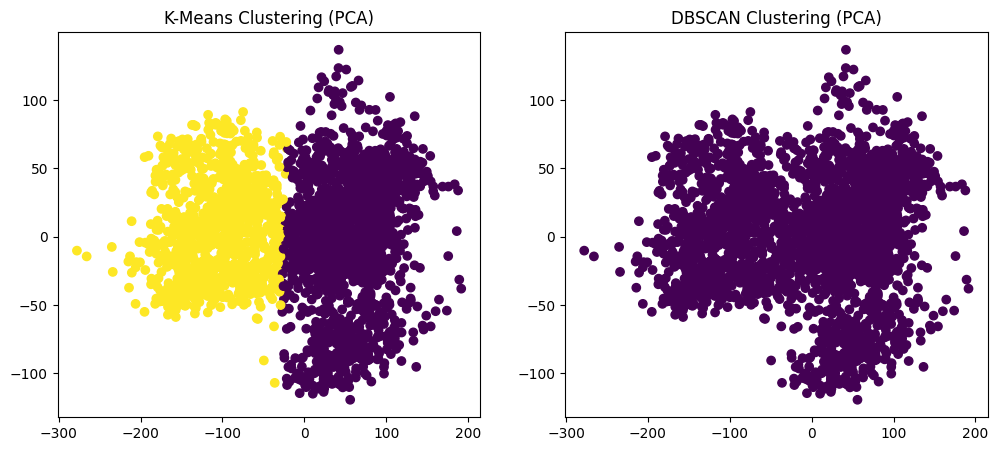

In [ ]:
# Cluster compactness and separation metrics
kmeans_inertia = kmeans.inertia_
kmeans_silhouette = silhouette_score(pca_result, kmeans_labels)
kmeans_db_index = davies_bouldin_score(pca_result, kmeans_labels)
dbscan_silhouette = silhouette_score(pca_result[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(np.unique(dbscan_labels[dbscan_labels != -1])) > 1 else -1
dbscan_db_index = davies_bouldin_score(pca_result[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(np.unique(dbscan_labels[dbscan_labels != -1])) > 1 else -1

print(f"K-Means Inertia: {kmeans_inertia}, Silhouette Score: {kmeans_silhouette}, Davies-Bouldin Index: {kmeans_db_index}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}, Davies-Bouldin Index: {dbscan_db_index}")

# Visual Interpretability
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("K-Means Clustering (PCA)")
plt.subplot(1, 2, 2)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=dbscan_labels, cmap='viridis')
plt.title("DBSCAN Clustering (PCA)")
plt.show()

K-Means Inertia: 13466872.0, Silhouette Score: 0.4968656301498413, Davies-Bouldin Index: 0.7570272354906818
DBSCAN Silhouette Score: -1, Davies-Bouldin Index: -1


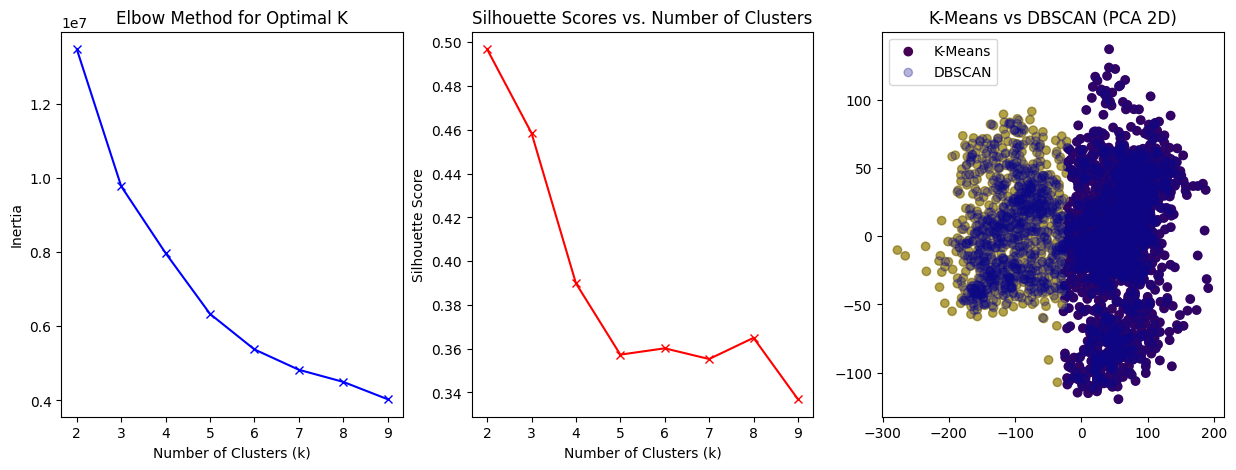

In [ ]:
# Cluster compactness and separation metrics
kmeans_inertia = kmeans.inertia_
kmeans_silhouette = silhouette_score(pca_result, kmeans_labels)
kmeans_db_index = davies_bouldin_score(pca_result, kmeans_labels)
dbscan_silhouette = silhouette_score(pca_result[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(np.unique(dbscan_labels[dbscan_labels != -1])) > 1 else -1
dbscan_db_index = davies_bouldin_score(pca_result[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(np.unique(dbscan_labels[dbscan_labels != -1])) > 1 else -1

print(f"K-Means Inertia: {kmeans_inertia}, Silhouette Score: {kmeans_silhouette}, Davies-Bouldin Index: {kmeans_db_index}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}, Davies-Bouldin Index: {dbscan_db_index}")

# Additional Plots
plt.figure(figsize=(15, 5))

# Plot 1: Elbow Curve
plt.subplot(1, 3, 1)
plt.plot(K, inertia, 'bx-')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

# Plot 2: Silhouette Scores
plt.subplot(1, 3, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.title("Silhouette Scores vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

# Plot 3: 2D Clustering Visualization
plt.subplot(1, 3, 3)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis', label='K-Means')
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=dbscan_labels, cmap='plasma', alpha=0.3, label='DBSCAN')
plt.title("K-Means vs DBSCAN (PCA 2D)")
plt.legend()
plt.show()